In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
import umap

In [2]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)
counties = df.pop('County')
latitude = df.pop('LAT')
longitude = df.pop('LON')
df.drop(['Virginia City/County Boundaries'], axis=1, inplace=True)

numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_data)

umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df = pd.concat([df, umap_df], axis=1)

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [3]:
def map_clusters(umap_1, umap_2):
    if (umap_1 < 2) and (umap_2 < 1):
        return 0
    elif (umap_1 >= 4) and (umap_2 <= 4):
        return 1
    elif (umap_2 > 4):
        return 2
    else: return -1

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


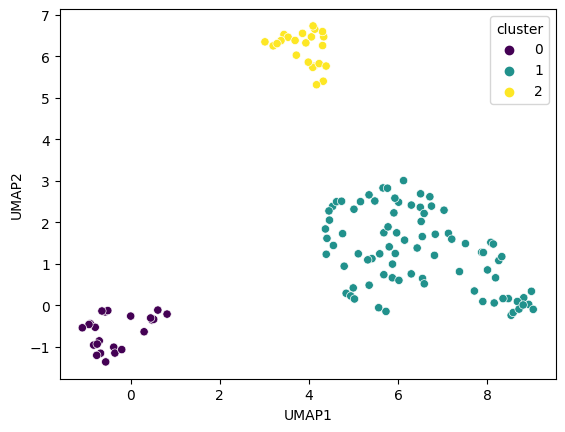

In [4]:
df['cluster'] = df.apply(lambda x: map_clusters(x['UMAP1'], x['UMAP2']), axis=1)
cluster_sizes = df.groupby('cluster').size()
df['weights'] = df['cluster'].apply(lambda x: 1 / cluster_sizes[x])

plt.figure()
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    data=df, hue='cluster',
    palette='viridis', legend='brief'
)
plt.show()

In [5]:
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
bank_score = np.log(imputed_score)

# Metric 1: Per Capita Distribution
df['PerCapitaDistribution'] = df['Pounds of Food Distributed'] / df['Pop2010']

# Metric 2: Percentage of Low-Income Population Served
df['PercentageLowIncome'] = df['TractLOWI'] / df['Pop2010']

# Metric 3: Percentage of Children Served
df['PercentageChildrenServed'] = df['Children Served via non-federal child nutrition programs'] / df['Pop2010']

metrics_to_try = [
    # (name, definition),
    ('PerCapitaDistribution', df['Pounds of Food Distributed'] / df['Pop2010']),
    ('PercentageLowIncome', df['TractLOWI'] / df['Pop2010']),
    ('PercentageChildrenServed', df['Children Served via non-federal child nutrition programs'] / df['Pop2010']),
    ('PercentageNonFederalPounds', df['Pounds of food distributed via non-federal child nutrition progr'] / df['Pop2010']),
    ('HouseHoldAndFoodPerLowPopulation', df['Households Served'] * df['Pounds of Food Distributed'] / df['Pop2010']),
    ('HouseHoldAndFoodPerLowIncome', df['Households Served'] * df['Pounds of Food Distributed'] / df['TractLOWI']),
    ('lbsFoodByLA1and10', df['Pounds of Food Distributed'] * df['LA1and10']),
    ('lbsFoodByLAPop1Share', df['Pounds of Food Distributed'] * (df['lapop1share'] * 0.01)),
    ('lbsFoodByLAKids1Share', df['Pounds of Food Distributed'] * (df['lakids1share'] * 0.01)),
    ('lbsFoodByLAPopHalfShare', df['Pounds of Food Distributed'] * (df['lapophalfshare'] * 0.01)),
    ('lbsFoodByLALowI1Share', df['Pounds of Food Distributed'] * (df['lalowi1share'] * 0.01)),
    ('lbsFoodByLAHunv1Share', df['Pounds of Food Distributed'] * (df['lahunv1share'] * 0.01)),
    ('lbsFoodByLASeniorsHalfShare', df['Pounds of Food Distributed'] * (df['laseniorshalfshare'] * 0.01)),
    ('lbsFoodByLALowIHalfShare', df['Pounds of Food Distributed'] * (df['lalowihalfshare'] * 0.01)),
    ('lbsFoodByLASNAP1Share', df['Pounds of Food Distributed'] * (df['lasnap1share'] * 0.01)),
    ('lbsFoodByPovertyRate', df['Pounds of Food Distributed'] * (df['PovertyRate'] * 0.01)),
    ('lbPerHouseServed', df['Pounds of Food Distributed'] / df['Households Served']),
    ('lbsPerIndivServed', df['Pounds of Food Distributed'] / df['Individuals Served']),
    ('PerCapitaDistributionByPovertyRate', (df['Pounds of Food Distributed'] / df['Pop2010']) * (df['PovertyRate'] * 0.01)),
    ('PerCapitaDistributionByIncome', (df['Pounds of Food Distributed'] / df['Pop2010']) * df['MedianFamilyIncome']),
    ('lbPerHouseByIncome', (df['Pounds of Food Distributed'] / df['OHU2010']) * df['MedianFamilyIncome']),
]

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

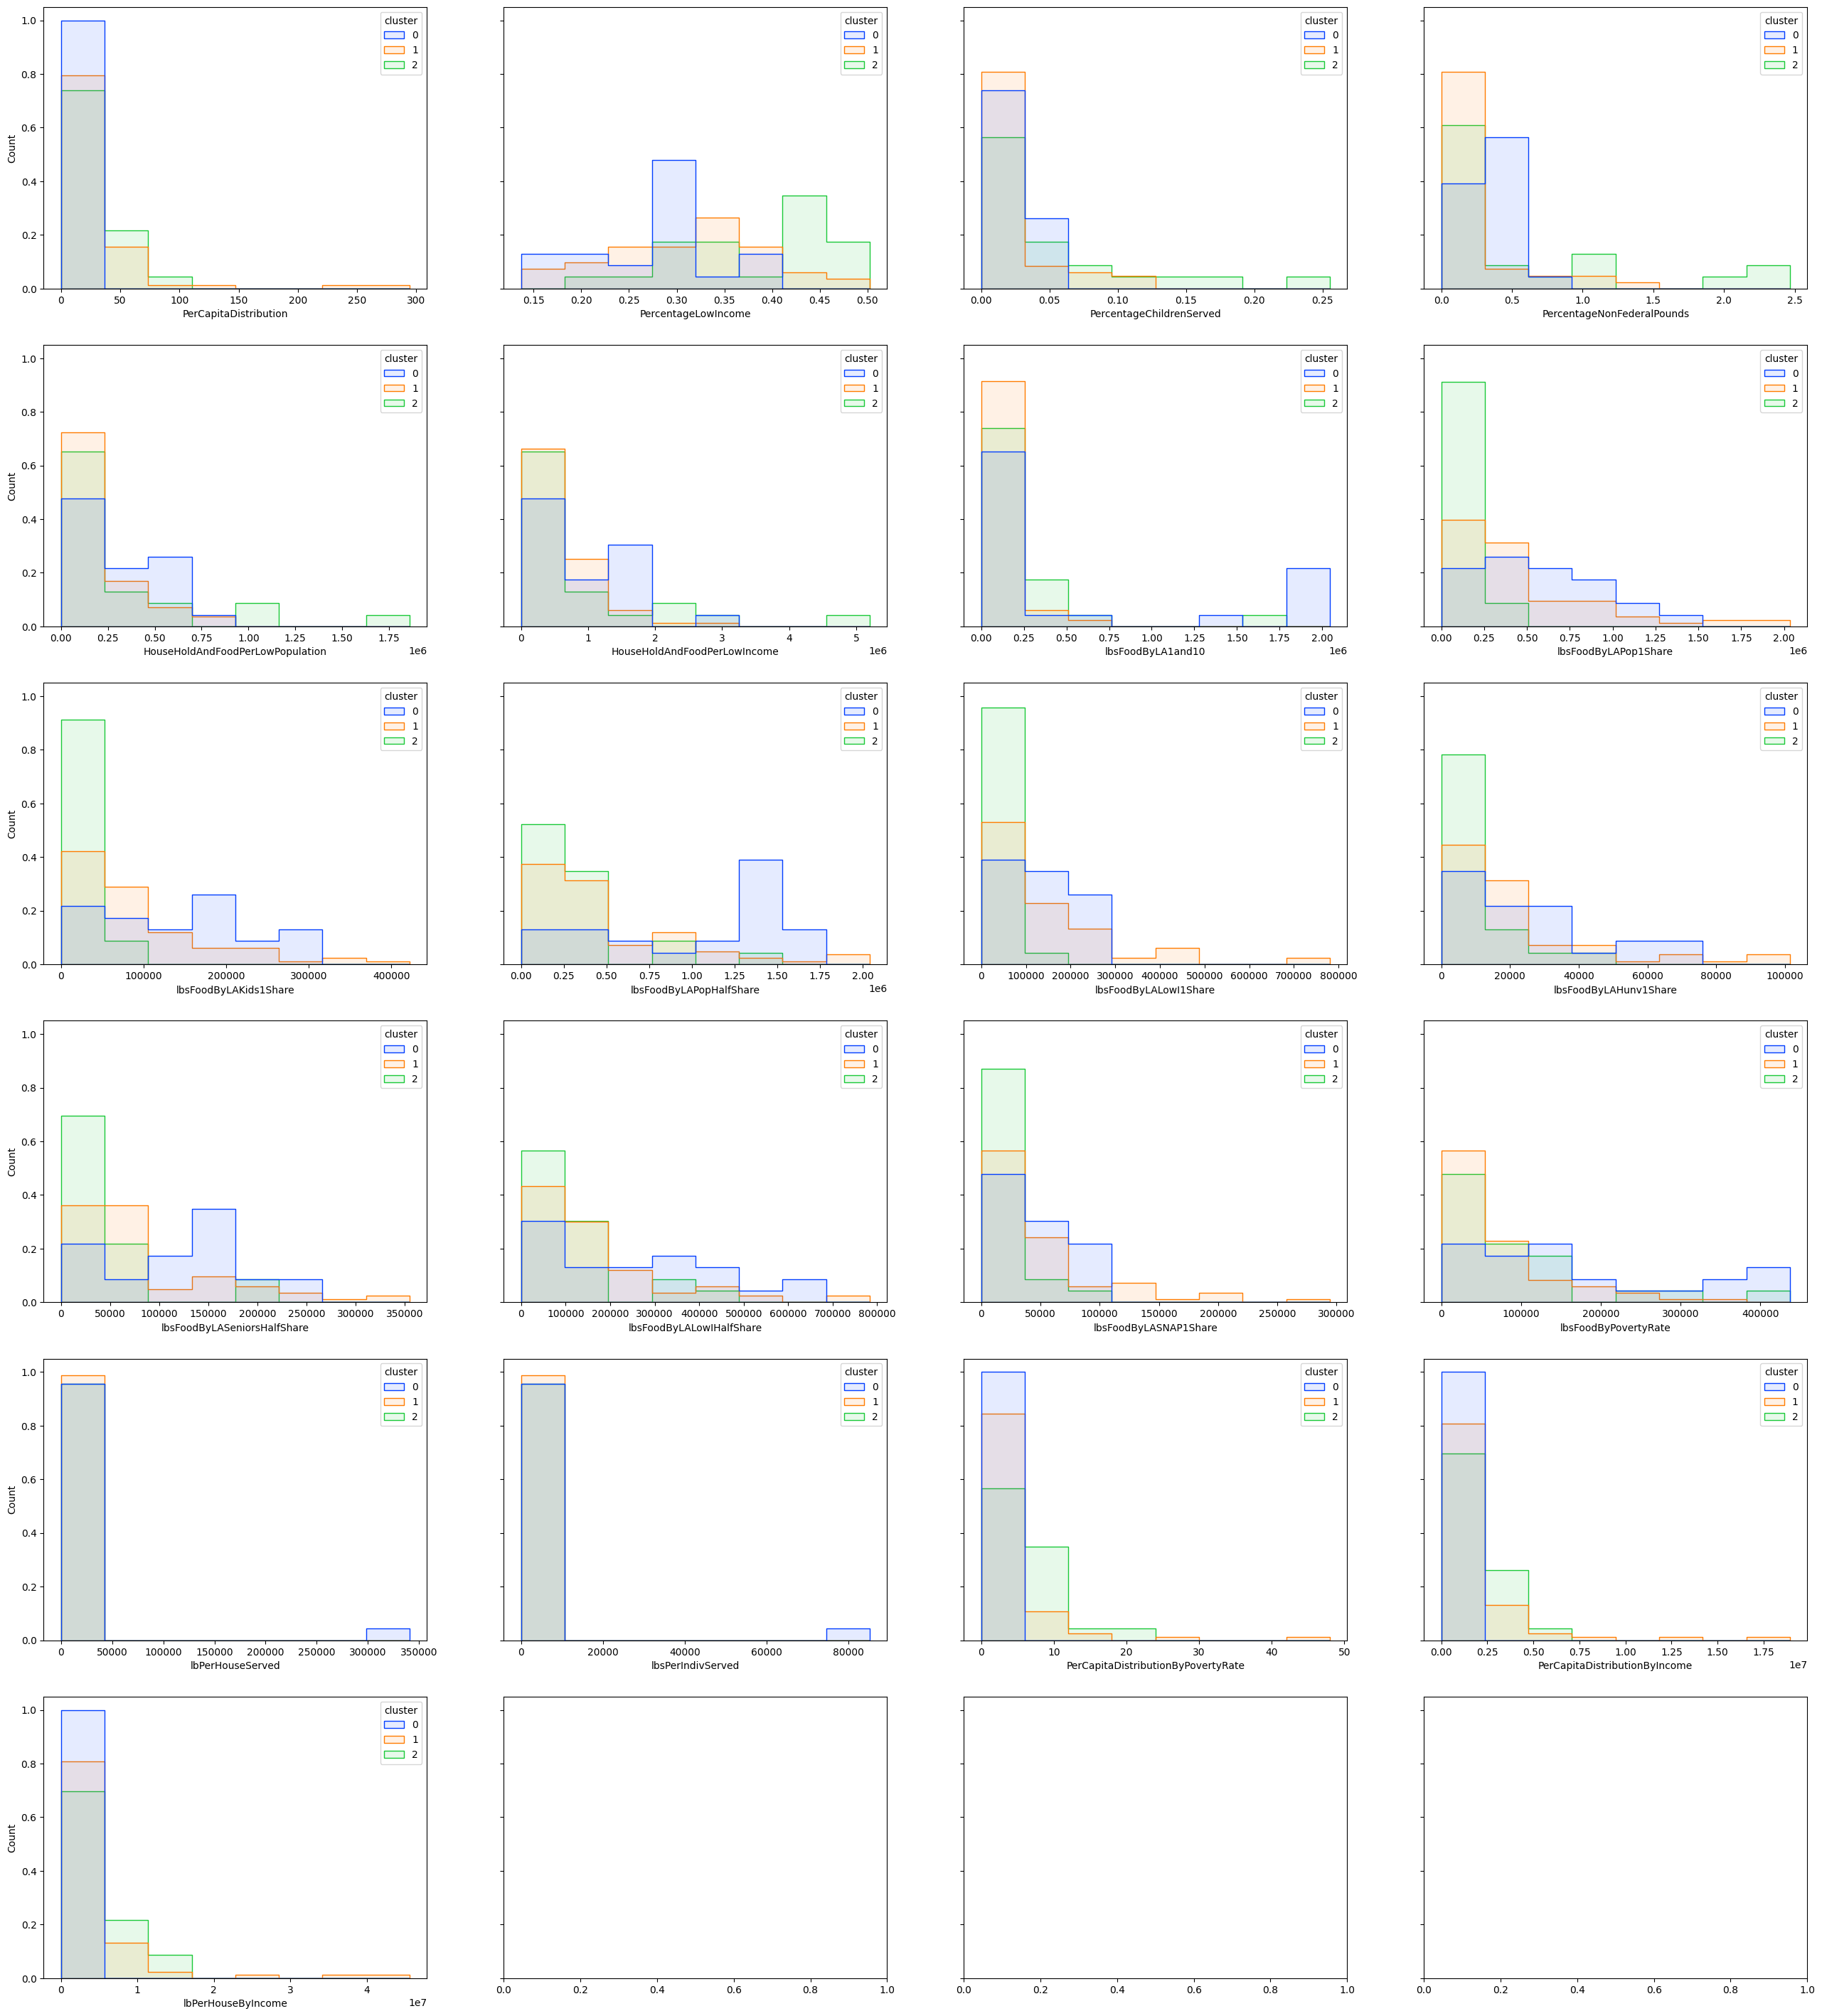

In [6]:
import math
ncols = 4
nrows = math.ceil(len(metrics_to_try) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*6), sharey=True)

for i, (feature, value) in enumerate(metrics_to_try):
    ax = axs[i // ncols][i % ncols]
    hist = sns.histplot(
        data=df, x=value, bins=8, hue='cluster', ax=ax,
        element='step', palette='bright', weights='weights', alpha=0.1
    )
    ax.set(xlabel=feature)
    # scatter.legend_.set_title(None)

plt.show()

In [7]:
def compare_feature(feature):
    print(f'Feature: {feature} (avg)')
    for cluster in (0,1,2):
        print(f'\tCluster {cluster}: {np.mean(df[df["cluster"] == cluster][feature])}')

compare_feature('Pop2010')
compare_feature('Pounds of Food Distributed')

Feature: Pop2010 (avg)
	Cluster 0: 103427.52173913043
	Cluster 1: 26158.433734939757
	Cluster 2: 25320.739130434784
Feature: Pounds of Food Distributed (avg)
	Cluster 0: 1403538.2108695654
	Cluster 1: 524278.39891566266
	Cluster 2: 491910.15668923775


In [8]:
df['Counties'] = counties
df['LAT'] = latitude
df['LON'] = longitude

In [9]:
df[df["cluster"] == 0].median(numeric_only=True)



Households Served                                                   2.191600e+04
Individuals Served                                                  7.841500e+04
Pounds of Food Distributed                                          1.899148e+06
Children Served via non-federal child nutrition programs            2.607000e+03
Pounds of food distributed via non-federal child nutrition progr    4.187000e+04
                                                                        ...     
PerCapitaDistribution                                               1.762267e+01
PercentageLowIncome                                                 3.078196e-01
PercentageChildrenServed                                            2.747774e-02
LAT                                                                 3.733108e+01
LON                                                                -7.745487e+01
Length: 108, dtype: float64

In [10]:
df[df["cluster"] == 0]

,Households Served,Individuals Served,Pounds of Food Distributed,Children Served via non-federal child nutrition programs,Pounds of food distributed via non-federal child nutrition progr,Pop2010,OHU2010,NUMGQTRS,LAPOP1_10,LAPOP05_10,...,UMAP1,UMAP2,cluster,weights,PerCapitaDistribution,PercentageLowIncome,PercentageChildrenServed,Counties,LAT,LON
1,29526.0,78415.0,2044282.70,857.0,18305.0,98970.0,38157.0,5010.5,11786.0,30767.0,...,0.300747,-0.632730,0,0.043478,20.655579,0.219188,0.008659,Albemarle County,38.024184,-78.553506
23,29526.0,88856.5,2044282.70,2607.0,41870.0,116003.0,48391.0,3721.0,24001.5,45586.5,...,-0.705882,-0.851821,0,0.043478,17.622671,0.307820,0.022474,Chesapeake City,36.679376,-76.301788
24,10658.0,88856.5,2044282.70,0.0,0.0,116003.0,48391.0,4651.0,24001.5,45586.5,...,-0.677458,-1.149994,0,0.043478,17.622671,0.307820,0.000000,Chesterfield County,37.378434,-77.585847
36,6.0,24.0,2044282.70,0.0,49517.5,116003.0,48391.0,5010.5,24001.5,45586.5,...,-0.763012,-1.200566,0,0.043478,17.622671,0.307820,0.000000,Fairfax County,38.833742,-77.276117
52,20258.0,51012.0,2044282.70,3187.5,49517.5,116003.0,48391.0,4454.0,24001.5,45586.5,...,-0.907502,-0.436923,0,0.043478,17.622671,0.307820,0.027478,Hampton City,37.048030,-76.297149
53,6930.0,38676.0,43661.00,0.0,0.0,99863.0,36589.0,1980.0,24001.5,45586.5,...,0.478525,-0.349361,0,0.043478,0.437209,0.146521,0.000000,Hanover County,37.760165,-77.490992
55,21916.0,88856.5,459326.00,0.0,0.0,116003.0,48391.0,2494.0,24001.5,45586.5,...,-0.831629,-0.952965,0,0.043478,3.959604,0.307820,0.000000,Henrico County,37.437520,-77.300333
60,2563.0,7268.0,1334575.00,2361.0,32806.0,67009.0,26860.0,1100.0,24001.5,45586.5,...,0.516116,-0.333275,0,0.043478,19.916355,0.198197,0.035234,James City County,37.324427,-76.778319
67,29526.0,88856.5,2023239.05,3187.5,49517.5,116003.0,48391.0,1172.0,24001.5,45586.5,...,-0.380824,-1.004113,0,0.043478,17.441265,0.307820,0.027478,Loudoun County,39.081130,-77.638857
70,29526.0,88856.5,1899148.36,3187.5,49517.5,75568.0,28476.0,5010.5,15163.0,45586.5,...,-0.572085,-0.153807,0,0.043478,25.131648,0.404589,0.042181,Lynchburg City,37.399016,-79.195458


In [11]:
counties[112]

'Spotsylvania County'

In [12]:
case_per_county = [(112, 'Soptsylvania County'), (44, 'Galax City')]

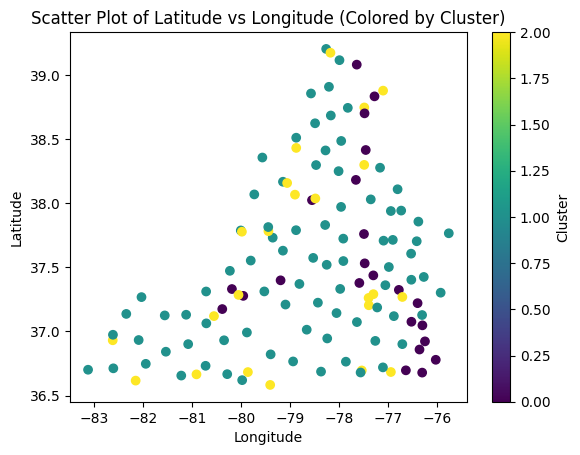

In [13]:
# Scatter plot with color-coded clusters
plt.scatter(df['LON'], df['LAT'], c=df['cluster'], cmap='viridis', marker='o')

# Add labels and a colorbar
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude (Colored by Cluster)')
plt.colorbar(label='Cluster')

# Show the plot
plt.show()


In [29]:
VA_LON = [-83.68, -75.38]
VA_LAT = [36.5, 39.47]

va_length = (VA_LON[1] - VA_LON[0]) 
va_height = (VA_LAT[1] - VA_LAT[0])

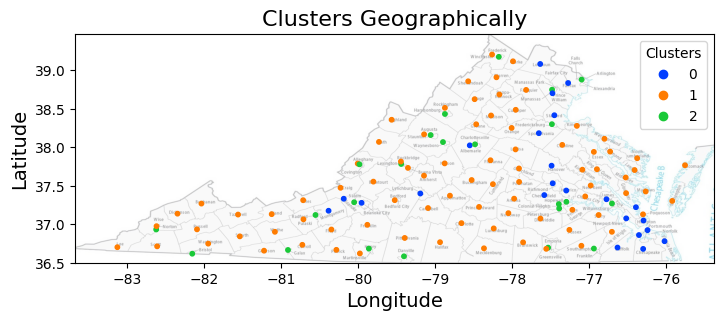

In [42]:
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

virginia_img = mpimg.imread('virginia.jpg')

plt.figure(figsize=(va_length, va_height))

# Scatter plot
scatter = plt.scatter(
    df['LON'],
    df['LAT'],
    # s=df['Pop2010'] / 1000,
    c=df['cluster'],
    cmap=ListedColormap(sns.color_palette('bright', 3).as_hex()),
    s=10
    # label='Population',
)

# Overlay the map of Virginia
plt.imshow(
    virginia_img,
    extent=[VA_LON[0], VA_LON[1], VA_LAT[0], VA_LAT[1]],
    alpha=0.5,
    # cmap=plt.get_cmap('jet'),
)

# Add legend for clusters
legend = plt.legend(*scatter.legend_elements(), title='Clusters', loc='upper right', fontsize=10)
legend.get_title().set_fontsize(10)

plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.title('Clusters Geographically', fontsize=16)

plt.savefig('clusters_geographically.png', bbox_inches='tight', dpi=1000)

plt.show()

